In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Set environment variables
import os

os.environ["SCAL_TYPE"] = "complex"
os.environ["PRECISION"] = "double"
os.environ["MY_NUMBA_TARGET"] = "numba"
 
# Add cle_fun to PYTHON_PATH
import sys
sys.path.append("/home/fabianhelmberger/temp/clonscal")

In [2]:
from sympy import symbols, exp, sqrt, diff
from sympy.functions.special.bessel import besselk

class Analytic:
    def __init__(self):
        self.sigma, self.lamda = symbols('sigma lamda')

    def derivative(self, sigma_value, lambda_value, derivative_order):
        if not hasattr(self, f'f_derivative{derivative_order}'):
            xi = self.sigma**2 / (8 * self.lamda)
            K_neg1_4 = besselk(-1/4, xi)
            f_sigma = sqrt(4 * xi / self.sigma) * exp(xi) * K_neg1_4
            f_derivative = diff(f_sigma, self.sigma, derivative_order)
            setattr(self, f"f_derivative{derivative_order}", f_derivative)

        f_derivative = getattr(self, f"f_derivative{derivative_order}")
        f_derivative_at_values = f_derivative.subs({self.sigma: sigma_value, self.lamda: lambda_value})
        return f_derivative_at_values.evalf()

    def n_moment(self, sigma_value, lambda_value, order):
        fac = (-2)**order 
        term1 = self.derivative(sigma_value, lambda_value, order)
        term2 = self.derivative(sigma_value, lambda_value, 0)
        
        return complex((fac * term1 / term2).evalf())

In [3]:
analytic = Analytic()


In [4]:
from simulation.config import Config
from simulation.cl_simulation import ComplexLangevinSimulation
from src.obs_kernels import n_moment_kernel
from tqdm import tqdm

config = Config(dt = 0.01, trajs = int(2), dims = [1], mass_real = 1, interaction = 2, ada_step = True)
sim = ComplexLangevinSimulation(config)
sim.register_observable('2_moment', obs_kernel=n_moment_kernel, const_param={'order': 2}, langevin_history=False, thermal_time=0, auto_corr=0.1)

Using double precision
Using C^1
Using Numba


In [5]:
def calculate_stats_complex(rolling_mean, rolling_sqr_mean, counter):
    """
    Calculate mean and SEM for complex numbers.
    
    Parameters:
    rolling_mean (np.array): Single-element array containing the rolling sum of complex values.
    rolling_sqr_mean (np.array): Single-element array containing the rolling sum of squared magnitudes of complex values.
    counter (np.array): Single-element array containing the number of values.
    
    Returns:
    tuple: (mean, sem_real, sem_imag), where:
        - mean is the complex mean,
        - sem_real is the SEM for the real part,
        - sem_imag is the SEM for the imaginary part.
    """
    if counter[0] == 0:
        raise ValueError("Counter cannot be zero to avoid division by zero.")
    
    # Extract real and imaginary parts
    rolling_mean_real = rolling_mean[0].real
    rolling_mean_imag = rolling_mean[0].imag
    
    # Mean calculation
    mean_real = rolling_mean_real / counter[0]
    mean_imag = rolling_mean_imag / counter[0]
    
    # Variance for real part
    rolling_sqr_mean_real = rolling_sqr_mean[0]
    variance = (rolling_sqr_mean_real / counter[0]) - mean_real**2 - mean_imag**2
    variance = max(variance, 0)
        
    # Standard error of the mean (SEM)
    sem = np.sqrt(variance / counter[0])
    
    # Return complex mean and SEM for real and imaginary parts
    mean = mean_real + 1j * mean_imag
    return mean, sem


In [6]:
from simulation.config import Config
from simulation.cl_simulation import ComplexLangevinSimulation
from src.obs_kernels import n_moment_kernel
from tqdm import tqdm

errors_dict = {'1_moment': [], '2_moment': []}
cl_estimate_dict = {'1_moment': [], '2_moment': []}
exact_dict = {'1_moment': [], '2_moment': []}
angles_dict = {'1_moment': [], '2_moment': []}
num = 64
sigma_abs = 4
analytic = Analytic()


for idx in tqdm(np.arange(num)):
    angle = idx/num*2*np.pi
    sigma = sigma_abs*(np.cos(angle) + 1j*np.sin(angle))
    config = Config(dt = 5e-3, trajs = int(1e4), dims = [1], mass_real = sigma, interaction = 2, ada_step = True)
    sim = ComplexLangevinSimulation(config)
    
    sim.register_observable('1_moment', obs_kernel=n_moment_kernel, const_param={'order': 1}, langevin_history=True, thermal_time=3, auto_corr=0.1)
    sim.register_observable('2_moment', obs_kernel=n_moment_kernel, const_param={'order': 2}, langevin_history=False, thermal_time=3, auto_corr=0.1)

    for _ in (range(int(1e3))):
        sim.step()
        for name, tr in sim.trackers.items():
            tr.mark_equilibrated_trajs()
            tr.compute()
    sim.finish()

    for name, tr in sim.trackers.items():
        mean, sem = calculate_stats_complex(tr.rolling_mean, tr.rolling_sqr_mean, tr.counter)
        cl_estimate_dict[name].append(mean)
        errors_dict[name].append(sem)
        angles_dict[name].append(angle)




100%|██████████| 64/64 [02:03<00:00,  1.93s/it]


In [7]:
exact_angles = np.linspace(0, 2*np.pi, 100)
exact_sigma = sigma_abs*(np.cos(exact_angles)+1j*np.sin(exact_angles))
exact_dict['1_moment'] = np.array([0 for _ in exact_sigma])
exact_dict['2_moment'] = np.array([analytic.n_moment(sigma, 2, 1) for sigma in exact_sigma])

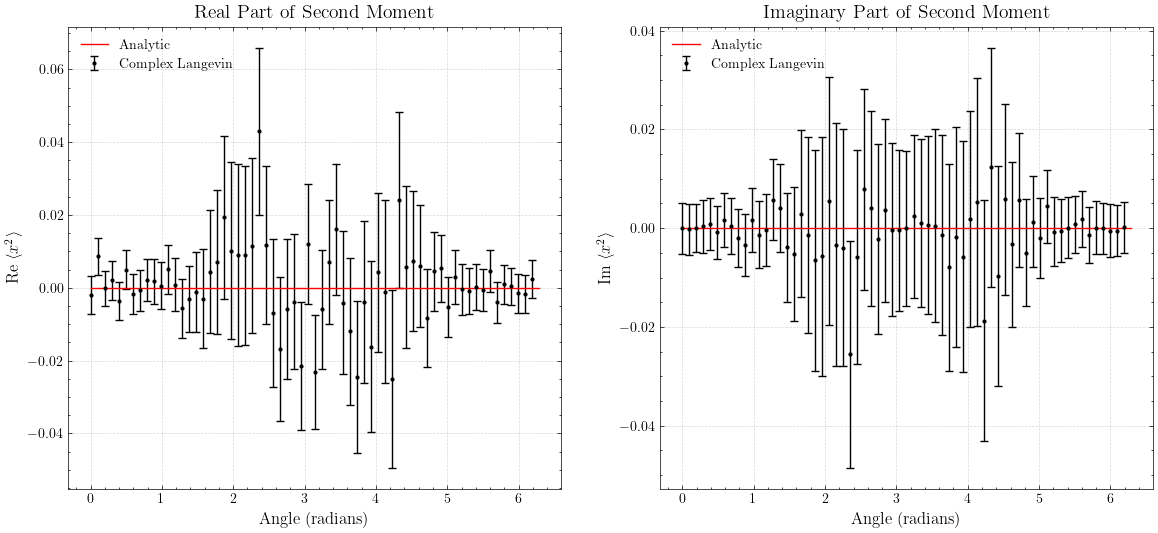

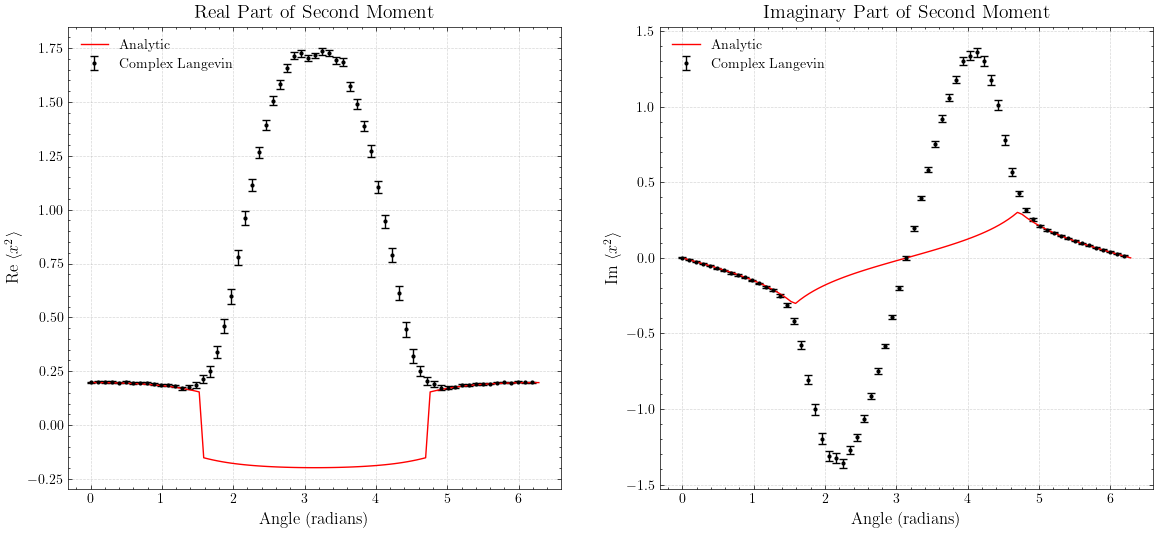

In [8]:
import scienceplots
plt.style.use('science')
for name, tr in sim.trackers.items():

    fig, axes = plt.subplots(1, 2, figsize=(14, 6)) 

    cl_estimate = np.array(cl_estimate_dict[name])
    errors = np.array(errors_dict[name])
    angles = np.array(angles_dict[name])

    axes[0].errorbar(angles, cl_estimate.real, yerr=2*np.abs(errors), fmt='o',color='black', capsize=3 ,label='Complex Langevin', markersize=2)
    axes[1].errorbar(angles, cl_estimate.imag, yerr=2*np.abs(errors), fmt='o',color='black', capsize=3 ,label='Complex Langevin', markersize=2)

    axes[0].plot(exact_angles, exact_dict[name].real, color='red', label = "Analytic")
    axes[1].plot(exact_angles, exact_dict[name].imag, color='red', label = "Analytic")

    # Titles
    axes[0].set_title('Real Part of Second Moment', fontsize=14)
    axes[1].set_title('Imaginary Part of Second Moment', fontsize=14)

    # Formatting
    for ax in axes:
        ax.set_xlabel('Angle (radians)', fontsize=12)
        ax.grid(alpha=0.5, linestyle='--')
        ax.legend(fontsize=10, loc = 'upper left')
        ax.tick_params(axis='both', which='major', labelsize=10)

    axes[0].set_ylabel(r'Re $\langle x^2 \rangle$', fontsize=12)
    axes[1].set_ylabel(r'Im $\langle x^2 \rangle$', fontsize=12)